# _tobac_ example: global MCS tracking in ICON NextGEMS simulation

In this example, we will explore tracking of mesoscale convective systems (MCSs) in global, km-scale ICON simulations. This example will consist of the following sections:

  1. Accessing model data remotely, visualisation
  2. Conversion of healpix grid data to a regular lat/lon grid for tracking
  3. Feature detection, tracking, segmentation and calculation of merges and splits on a large domain with periodic boundaries
  4. Conversion of segmentation mask back to healpix grid
  5. Filtering and analysis of detected storms

The tracking of MCSs in this example follows the MCS tracking model intercomparison (MCSMIP) protocol - https://mcsmip.github.io/ - and is based on the _tobac_ process chain for DYAMOND phase 1/2 model data (https://github.com/w-k-jones/tobac-mcsmip)

In [2]:
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs

import intake
import healpix
import easygems.healpix as egh

import tobac

In [3]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

## Data access and pre-processing

We start by accessing the online NextGEMS catalogue. The cycle 4 ICON model data is stored in healpix form, which is a hierarchichal format with multiple time and spatial resolution options:

In [4]:
cat = intake.open_catalog("https://data.nextgems-h2020.eu/online.yaml")

pd.DataFrame(cat.ICON.ngc4008.describe()["user_parameters"])

,name,description,type,allowed,default
0,time,time resolution of the dataset,str,"[PT15M, PT3H, P1D]",P1D
1,zoom,zoom resolution of the dataset,int,"[10, 9, 8, 7, 6, 5, 4, 3, 2, 1, 0]",0


In general, it is optimal to perform feature detection and tracking at the highest available resolutions, which is 15 minutes (PT15M) and zoom 9 (zoom 10 is only stored at lower time resolutions) for this simulation. However, to reduce the computation time of this example we will work at a lower zoom level of 7, which is approximately close to a 0.5 degree lat/lon grid

In [5]:
zoom = 7
grid_spacing = 64 / 2**zoom
dxy = 1e5 * grid_spacing

In [6]:
icon_ds = cat.ICON.ngc4008(
    zoom=zoom, time="PT15M", chunks={}
).to_dask().pipe(egh.attach_coords)

In [7]:
icon_ds

<xarray.Dataset> Size: 5TB
Dimensions:  (time: 1051968, cell: 196608)
Coordinates:
  * time     (time) datetime64[ns] 8MB 2020-01-01T00:15:00 ... 2050-01-01
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0
Data variables:
    pr       (time, cell) float32 827GB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    qv2m     (time, cell) float32 827GB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    rlut     (time, cell) float32 827GB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    rsds     (time, cell) float32 827GB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    sfcwind  (time, cell) float32 827GB dask.array<chunksize=(192, 16384), meta=np.ndarray>
    tas      (time, cell) float32 827GB dask.array<chunksize=(192, 16384), meta=np.ndarray>

The cycle 4 NextGEMS simulation spans 30 years, however as we have only created a dask dataset we have not actually loaded any of it. For this example, we will select the 3 variables of interest (precipitation, OLR and surface air temperature) over 1 day:

In [8]:
icon_ds = icon_ds[["pr", "rlut", "tas"]].sel(time=slice(datetime(2024,7,1), datetime(2024,7,2))).load()

Visualise the fields:

Text(0.5, 1.0, 'OLR')

<Figure size 640x480 with 0 Axes>

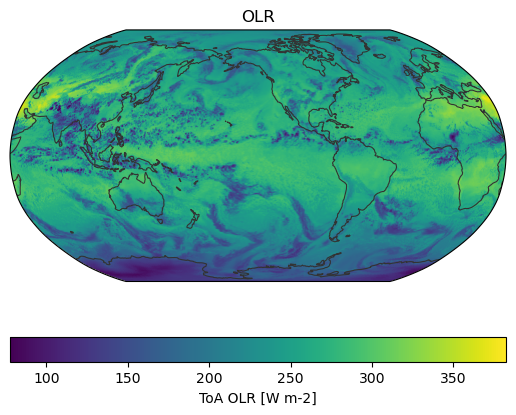

In [9]:
img = egh.healpix_show(icon_ds.rlut[42])
plt.colorbar(img, orientation="horizontal", label="ToA OLR [W m-2]")
plt.title("OLR")

Text(0.5, 1.0, 'Precip')

<Figure size 640x480 with 0 Axes>

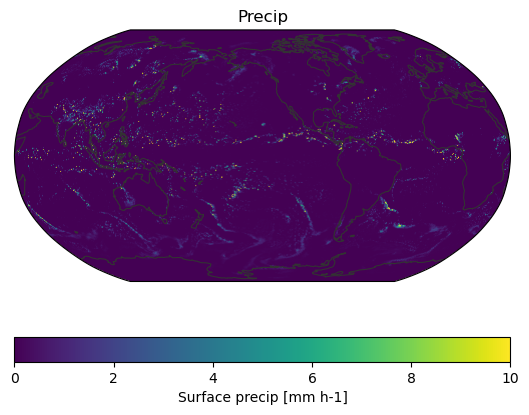

In [10]:
img = egh.healpix_show(icon_ds.pr[42] * 3.6e3, vmax=10)
plt.colorbar(img, orientation="horizontal", label="Surface precip [mm h-1]")
plt.title("Precip")

Text(0.5, 1.0, 'Surface air temperature')

<Figure size 640x480 with 0 Axes>

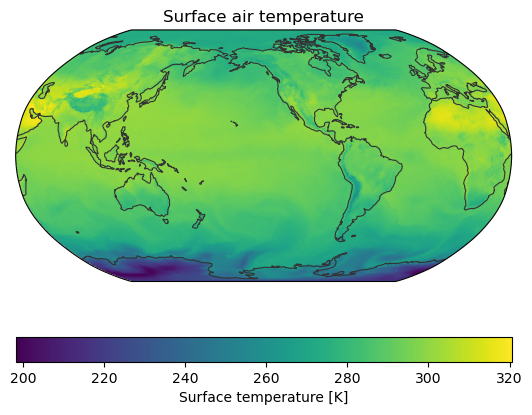

In [11]:
img = egh.healpix_show(icon_ds.tas[42])
plt.colorbar(img, orientation="horizontal", label="Surface temperature [K]")
plt.title("Surface air temperature")

OLR is commonly used for anvil tracking, but in global simulations the variation in OLR across latitudes can result in erroneous detections in the winter hemisphere near the poles. Precip could also be used for tracking intensely precipitating storms, but would miss the decaying stage of the anvil.

To address the issues with OLR, we can instead approximate the atmosphere contribution to OLR by subtracting OLR from the black body radiation of the surface air temperature. This results in a field where high clouds have large values, but cold, clear sky scenes have low values

<Figure size 640x480 with 0 Axes>

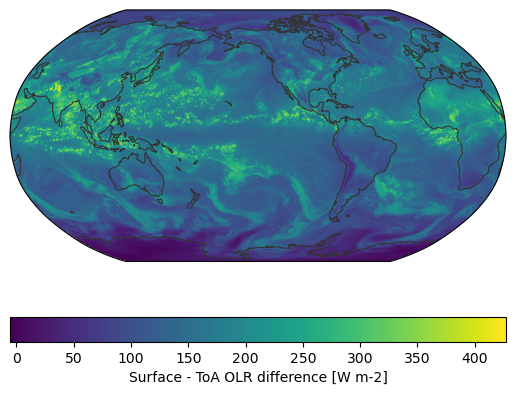

In [31]:
icon_ds['surface_olr_diff'] = (icon_ds.tas**4 * 5.67e-8) - icon_ds.rlut

img = egh.healpix_show(surface_olr_diff[42])
plt.colorbar(img, orientation="horizontal", label="Surface - ToA OLR difference [W m-2]")

11 micron brightness temperature (BT) can be approximated from OLR using the function below:

In [13]:
def get_tb(olr):
    """
    This function converts outgoing longwave radiation to brightness temperatures.

    Args:
        olr(xr.DataArray or numpy array): 2D field of model output with OLR

    Returns:
        tb(xr.DataArray or numpy array): 2D field with estimated brightness temperatures
    """
    # constants
    aa = 1.228
    bb = -1.106e-3  # K−1
    # Planck constant
    sigma = 5.670374419e-8  # W⋅m−2⋅K−4

    # flux equivalent brightness temperature
    Tf = (abs(olr) / sigma) ** (1.0 / 4)
    tb = (((aa**2 + 4 * bb * Tf) ** (1.0 / 2)) - aa) / (2 * bb)
    return tb

Text(0.5, 1.0, 'ToA BT')

<Figure size 640x480 with 0 Axes>

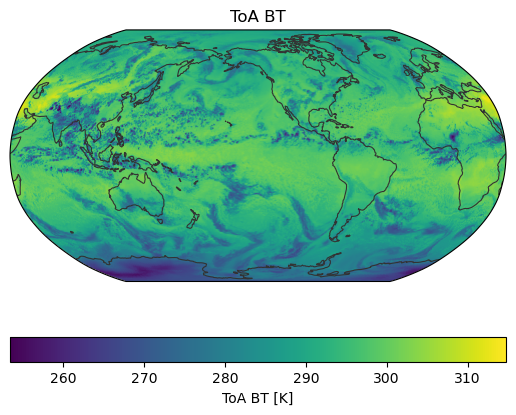

In [19]:
icon_ds['tb'] = get_tb(icon_ds.rlut)
img = egh.healpix_show(get_tb(icon_ds.tb[42]))
plt.colorbar(img, orientation="horizontal", label="ToA BT [K]")
plt.title("ToA BT")

In [27]:
icon_ds.tb

<xarray.DataArray 'tb' (time: 97, cell: 196608)> Size: 76MB
array([[289.07547, 288.9619 , 289.86948, ..., 294.93768, 282.84644,
        289.2069 ],
       [288.8215 , 288.14456, 288.43604, ..., 294.75644, 285.4071 ,
        290.1857 ],
       [288.77963, 287.49823, 285.7593 , ..., 294.44803, 288.3772 ,
        290.78595],
       ...,
       [279.4566 , 280.67374, 286.69812, ..., 285.57996, 289.4251 ,
        288.7982 ],
       [278.6985 , 280.1743 , 286.22284, ..., 284.84167, 290.19653,
        289.52255],
       [279.42566, 279.599  , 285.88547, ..., 284.58447, 290.66306,
        290.28073]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 776B 2024-07-01 ... 2024-07-02
    crs      int64 8B 0
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
    lat      (cell) float64 2MB 0.2984 0.5968 0.5968 ... -0.5968 -0.5968 -0.2984
    lon      (cell) float64 2MB 45.0 45.35 44.65 45.0 ... 315.4 314.6 315.0

We can further examine the distributions of the OLR field and corresponding BT as shown below:

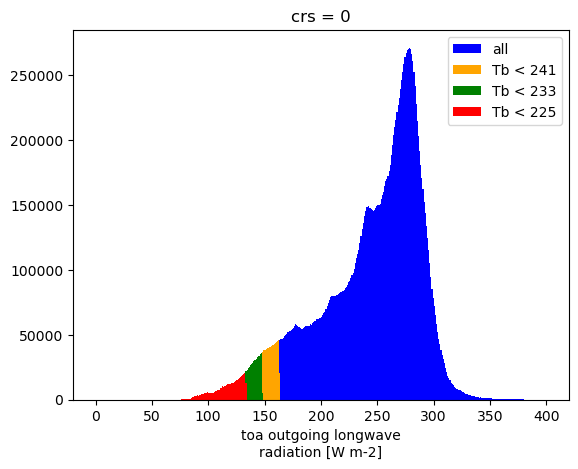

In [29]:
colors = ['blue', 'orange', 'green', 'red']
threshs = [None, 241, 233, 225]
labels = [f'Tb < {t}' if t else 'all' for t in threshs]
for c, t, l in zip(colors, threshs, labels):
    if t:
        h = icon_ds.rlut.where(icon_ds.tb<=t).plot.hist(bins=np.arange(401), color=c, label=l)
    else:
        h = icon_ds.rlut.plot.hist(bins=np.arange(401), color=c, label=l)
plt.legend();

Different BT thresholds correspond directly to OLR thresholds, but this means that cold surface scenes will also be detected. With the surface - OLR difference, as plotted below, we can see two sets of peaks for cold brightness temperatures; one, at low values indicates cold surfaces while the large value peaks are the anvil clouds we are interest in detecting

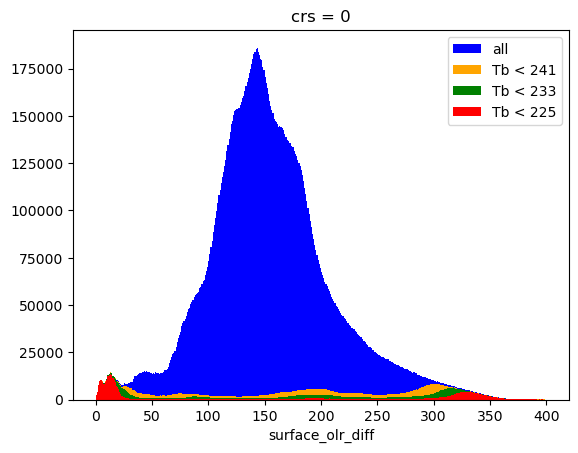

In [57]:
for c, t, l in zip(colors, threshs, labels):
    if t is None:
        t = icon_ds.tb.max()
    h = icon_ds.surface_olr_diff.where(icon_ds.tb<=t).plot.hist(bins=np.arange(401), color=c, label=l)
plt.legend();

From the distribution, thresholds of 250-300 W m-2 seen reasonable

## Regrid ICON data to regular lat/lon grid for tracking:

The simplest approach to regridding is to use nearest neighbours after finding the cells matching a lat/lon grid using the `healpix.ang2pix` function:

In [34]:
def latlon_remap_cells(grid_spacing, crs):
    lon = xr.DataArray(
        np.arange(grid_spacing/2, 360, grid_spacing),
        dims=("lon",), 
        name="lon", 
        attrs=dict(units="degrees", standard_name="longitude")
    )
    lat = xr.DataArray(
        np.arange(90 - grid_spacing/2, -90, -grid_spacing), 
        dims=("lat",), 
        name="lat", 
        attrs=dict(units="degrees", standard_name="latitude")
    )

    return xr.DataArray(
        healpix.ang2pix(crs.healpix_nside, *np.meshgrid(lon, lat), nest=crs.healpix_order == 'nest', lonlat=True),
        coords=(lat, lon),
    )


In [35]:
pix = latlon_remap_cells(grid_spacing, icon_ds.crs)

In [49]:
icon_ds.crs.healpix_order

'nest'

We can then perform the regridding using xarray's nearest neighbour selection:

In [43]:
surface_olr_diff_gridded = surface_olr_diff.drop_vars(["lat", "lon"], errors="ignore").sel(cell=pix, method="nearest")

In [179]:
surface_olr_diff_gridded

<xarray.DataArray (time: 97, lat: 360, lon: 720)> Size: 101MB
array([[[ 89.56607  ,  89.56607  ,  89.56607  , ...,  91.1358   ,
          91.1358   ,  91.1358   ],
        [ 91.90077  ,  91.90077  ,  91.90077  , ...,  96.54138  ,
          96.54138  ,  96.54138  ],
        [100.12166  , 100.12166  , 100.12166  , ...,  97.58531  ,
          97.58531  ,  97.58531  ],
        ...,
        [  9.420959 ,   9.420959 ,   9.420959 , ...,  10.78727  ,
          10.78727  ,  10.78727  ],
        [  9.191551 ,   9.191551 ,   9.191551 , ...,   8.262306 ,
           8.262306 ,   8.262306 ],
        [  8.498383 ,   8.498383 ,   8.498383 , ...,   7.873596 ,
           7.873596 ,   7.873596 ]],

       [[ 89.22284  ,  89.22284  ,  89.22284  , ...,  91.391785 ,
          91.391785 ,  91.391785 ],
        [ 90.07083  ,  90.07083  ,  90.07083  , ...,  96.23041  ,
          96.23041  ,  96.23041  ],
        [102.35628  , 102.35628  , 102.35628  , ...,  93.810165 ,
          93.810165 ,  93.810165 ],
...
        [ 13.379158 ,  13.379158 ,  13.379158 , ...,  14.278435 ,
          14.278435 ,  14.278435 ],
        [ 14.253799 ,  14.253799 ,  14.253799 , ...,  13.540749 ,
          13.540749 ,  13.540749 ],
        [ 14.201973 ,  14.201973 ,  14.201973 , ...,  13.139412 ,
          13.139412 ,  13.139412 ]],

       [[ 72.92326  ,  72.92326  ,  72.92326  , ...,  74.285355 ,
          74.285355 ,  74.285355 ],
        [ 72.94551  ,  72.94551  ,  72.94551  , ...,  72.57539  ,
          72.57539  ,  72.57539  ],
        [ 72.74133  ,  72.74133  ,  72.74133  , ...,  72.03839  ,
          72.03839  ,  72.03839  ],
        ...,
        [ 13.633156 ,  13.633156 ,  13.633156 , ...,  14.5451355,
          14.5451355,  14.5451355],
        [ 14.586899 ,  14.586899 ,  14.586899 , ...,  13.576523 ,
          13.576523 ,  13.576523 ],
        [ 14.456612 ,  14.456612 ,  14.456612 , ...,  13.28611  ,
          13.28611  ,  13.28611  ]]], dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 776B 2024-07-01 ... 2024-07-02
    crs      int64 8B 0
    cell     (lat, lon) int64 2MB 16383 16383 16383 ... 180224 180224 180224
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8

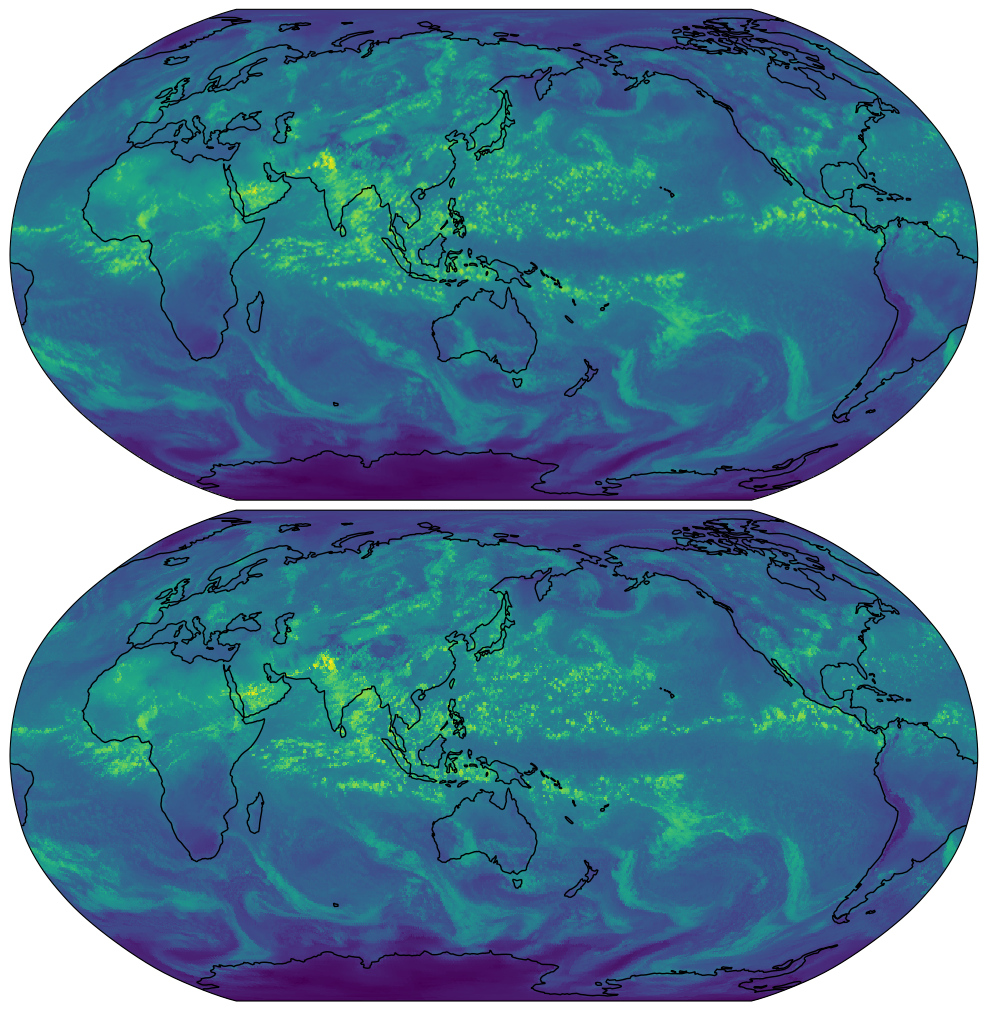

In [55]:
proj = ccrs.Robinson(central_longitude=137)
fig, (ax0, ax1) = plt.subplots(2, 1, figsize=(10, 10), subplot_kw={'projection': proj}, layout='constrained')
for ax in (ax0, ax1):
    ax.set_global()
    ax.coastlines()
egh.healpix_show(surface_olr_diff.isel(time=42), ax=ax0)
ax1.pcolormesh(surface_olr_diff_gridded.lon, surface_olr_diff_gridded.lat, surface_olr_diff_gridded.isel(time=42), transform=ccrs.PlateCarree())

## Feature detection and tracking using _tobac_

The object detection process consists of four steps within _tobac_:

1. feature_detection
2. tracking
3. merging/splitting
4. segmentation

First, we start with feature detection using multiple thresholds, periodic boundaries in the x direction

In [58]:
Features = tobac.feature_detection_multithreshold(
    surface_olr_diff_gridded.drop_vars(["cell", "crs"], errors="ignore"), 
    dxy=dxy, threshold=[250, 275, 300, 325], min_distance=dxy*4, PBC_flag="hdim_2"
)

In [59]:
Features

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude
0,0,1,35.000000,229.000000,1,250,1,2024-07-01 00:00:00,2024-07-01 00:00:00,72.250000,114.750000
1,0,2,39.400000,504.799998,5,250,2,2024-07-01 00:00:00,2024-07-01 00:00:00,70.050000,252.649999
2,0,3,43.307692,327.269236,26,250,3,2024-07-01 00:00:00,2024-07-01 00:00:00,68.096154,163.884618
3,0,5,49.666667,337.333332,3,250,4,2024-07-01 00:00:00,2024-07-01 00:00:00,64.916667,168.916666
4,0,7,53.142857,492.285716,7,250,5,2024-07-01 00:00:00,2024-07-01 00:00:00,63.178571,246.392858
...,...,...,...,...,...,...,...,...,...,...,...
62844,96,1448,198.166667,189.833332,6,325,82401,2024-07-02 00:00:00,2024-07-02 00:00:00,-9.333333,95.166666
62845,96,1449,200.400000,194.200002,5,325,82402,2024-07-02 00:00:00,2024-07-02 00:00:00,-10.450000,97.350001
62846,96,1450,201.666667,187.333332,3,325,82403,2024-07-02 00:00:00,2024-07-02 00:00:00,-11.083333,93.916666
62847,96,1451,203.000000,311.000000,1,325,82404,2024-07-02 00:00:00,2024-07-02 00:00:00,-11.750000,155.750000


Then we perform tracking using motion prediction:

In [60]:
Tracks = tobac.linking_trackpy(
    Features, None, dt=900, dxy=dxy, v_max=50, 
    method_linking="predict", stubs=2, 
    PBC_flag="hdim_2", min_h2=0, max_h2=surface_olr_diff_gridded.lon.size
)

Frame 96: 670 trajectories present.


In [61]:
Tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,latitude,longitude,cell,time_cell
0,0,1,35.000000,229.000000,1,250,1,2024-07-01 00:00:00,2024-07-01 00:00:00,72.250000,114.750000,-1,NaT
1,0,2,39.400000,504.799998,5,250,2,2024-07-01 00:00:00,2024-07-01 00:00:00,70.050000,252.649999,2,0 days 00:00:00
2,0,3,43.307692,327.269236,26,250,3,2024-07-01 00:00:00,2024-07-01 00:00:00,68.096154,163.884618,3,0 days 00:00:00
3,0,5,49.666667,337.333332,3,250,4,2024-07-01 00:00:00,2024-07-01 00:00:00,64.916667,168.916666,4,0 days 00:00:00
4,0,7,53.142857,492.285716,7,250,5,2024-07-01 00:00:00,2024-07-01 00:00:00,63.178571,246.392858,5,0 days 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...
62844,96,1448,198.166667,189.833332,6,325,82401,2024-07-02 00:00:00,2024-07-02 00:00:00,-9.333333,95.166666,16388,0 days 01:00:00
62845,96,1449,200.400000,194.200002,5,325,82402,2024-07-02 00:00:00,2024-07-02 00:00:00,-10.450000,97.350001,16389,0 days 01:00:00
62846,96,1450,201.666667,187.333332,3,325,82403,2024-07-02 00:00:00,2024-07-02 00:00:00,-11.083333,93.916666,16633,0 days 00:45:00
62847,96,1451,203.000000,311.000000,1,325,82404,2024-07-02 00:00:00,2024-07-02 00:00:00,-11.750000,155.750000,16223,0 days 01:15:00


Merging/splitting finds features that start/end less than dxy*4 distance and 1 time step away from others:

In [62]:
merges_splits = tobac.merge_split.merge_split_MEST(
    Tracks, dxy=dxy, distance=dxy*4, frame_len=1, PBC_flag="hdim_2", min_h2=0, max_h2=surface_olr_diff_gridded.lon.size
)

TypeError: unsupported operand type(s) for *: 'NoneType' and 'float'

In [234]:
merges_splits

<xarray.Dataset> Size: 2MB
Dimensions:                   (cell: 11085, feature: 62849, track: 5570)
Coordinates:
  * cell                      (cell) int64 89kB 2 3 4 5 ... 16965 16966 16967
  * feature                   (feature) int64 503kB 1 2 3 ... 82403 82404 82405
  * track                     (track) int64 45kB 1 2 3 4 ... 5567 5568 5569 5570
Data variables:
    cell_parent_track_id      (cell) int64 89kB 1 2 3 4 ... 4923 5570 5349 2600
    feature_parent_cell_id    (feature) int64 503kB -1 2 3 ... 16633 16223 15662
    feature_parent_track_id   (feature) int64 503kB -1 1 2 3 ... 5460 4497 2307
    track_child_cell_count    (track) int64 45kB 1 2 1 2 1 1 1 ... 1 1 1 1 1 1 1
    cell_child_feature_count  (cell) int64 89kB 10 7 2 2 2 2 2 ... 2 2 2 2 2 2 2
    cell_starts_with_split    (cell) bool 11kB False False False ... True True
    cell_ends_with_merge      (cell) bool 11kB False True False ... False False

In [235]:
Tracks["track"] = merges_splits.feature_parent_track_id
Tracks["time_track"] = Tracks.time - Tracks.groupby("track").time.min()[Tracks.track].to_numpy()

Finally, we perform a watershed segmentation to find the area surrounding each feature to a threshold of 225 W m-2

In [236]:
segmentation_mask, Tracks = tobac.segmentation.segmentation(
    Tracks, surface_olr_diff_gridded, dxy=dxy, threshold=225, PBC_flag="hdim_2", seed_3D_flag="box"
)

In [237]:
segmentation_mask

<xarray.DataArray 'segmentation_mask' (time: 97, lat: 360, lon: 720)> Size: 201MB
array([[[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
...
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]],

       [[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]]])
Coordinates:
  * time     (time) datetime64[ns] 776B 2024-07-01 ... 2024-07-02
    crs      int64 8B 0
    cell     (lat, lon) int64 2MB 16383 16383 16383 ... 180224 180224 180224
  * lat      (lat) float64 3kB 89.75 89.25 88.75 88.25 ... -88.75 -89.25 -89.75
  * lon      (lon) float64 6kB 0.25 0.75 1.25 1.75 ... 358.2 358.8 359.2 359.8
Attributes:
    threshold:  225

In [238]:
Tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,lon,cell,time_cell,track,ncells
0,0,1,35.000000,229.000000,1,250,1,2024-07-01,2024-07-01 00:00:00,72.250000,114.750000,-1,NaT,-1,41
1,0,2,39.400000,504.799998,5,250,2,2024-07-01,2024-07-01 00:00:00,70.050000,252.649999,2,0 days 00:00:00,1,17
2,0,3,43.307692,327.269236,26,250,3,2024-07-01,2024-07-01 00:00:00,68.096154,163.884618,3,0 days 00:00:00,2,90
3,0,5,49.666667,337.333332,3,250,4,2024-07-01,2024-07-01 00:00:00,64.916667,168.916666,4,0 days 00:00:00,3,31
4,0,7,53.142857,492.285716,7,250,5,2024-07-01,2024-07-01 00:00:00,63.178571,246.392858,5,0 days 00:00:00,4,27
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62844,96,1448,198.166667,189.833332,6,325,82401,2024-07-02,2024-07-02 00:00:00,-9.333333,95.166666,16388,0 days 01:00:00,3805,35
62845,96,1449,200.400000,194.200002,5,325,82402,2024-07-02,2024-07-02 00:00:00,-10.450000,97.350001,16389,0 days 01:00:00,5390,23
62846,96,1450,201.666667,187.333332,3,325,82403,2024-07-02,2024-07-02 00:00:00,-11.083333,93.916666,16633,0 days 00:45:00,5460,20
62847,96,1451,203.000000,311.000000,1,325,82404,2024-07-02,2024-07-02 00:00:00,-11.750000,155.750000,16223,0 days 01:15:00,4497,31


In [239]:
Tracks = tobac.calculate_area(
    Tracks, segmentation_mask, method_area="latlon", 
)

/Users/jonesw/miniforge3/envs/tobac-dev/lib/python3.12/site-packages/iris/analysis/cartography.py:435: IrisDefaultingWarning: Using DEFAULT_SPHERICAL_EARTH_RADIUS.
  warnings.warn(


## Conversion of object masks back to Healpix format

To make subsequent analysis, we will tranform the object masks created by the segmentation back to the Healpix grid format using a reversal of the previous regridding using `healpix.pix2ang`

In [240]:
remap_lons, remap_lats = healpix.pix2ang(
    icon_ds.crs.healpix_nside, icon_ds.cell, nest=icon_ds.crs.healpix_order, lonlat=True,
)
remap_lons = remap_lons % 360

In [241]:
segmentation_mask_hp = segmentation_mask.drop_vars(["cell"]).sel(
    lon=xr.DataArray(remap_lons, dims="cell", coords={"cell":icon_ds.cell}), 
    lat=xr.DataArray(remap_lats, dims="cell", coords={"cell":icon_ds.cell}), 
    method="nearest"
)

In [242]:
segmentation_mask_hp

<xarray.DataArray 'segmentation_mask' (time: 97, cell: 196608)> Size: 153MB
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])
Coordinates:
  * time     (time) datetime64[ns] 776B 2024-07-01 ... 2024-07-02
    crs      int64 8B 0
    lat      (cell) float64 2MB 0.25 0.75 0.75 0.75 ... -0.75 -0.75 -0.75 -0.25
    lon      (cell) float64 2MB 45.25 45.25 44.75 45.25 ... 315.2 314.8 315.2
  * cell     (cell) int64 2MB 0 1 2 3 4 5 ... 196603 196604 196605 196606 196607
Attributes:
    threshold:  225

We can plot how the two masks appear in lat/lon and healpix format:

Text(0.5, 1.0, 'tobac ICON segmentation lat/lon')

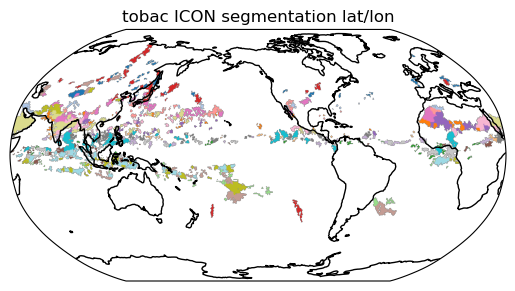

In [243]:
import cartopy.crs as ccrs
fig, ax = plt.subplots(subplot_kw={"projection":ccrs.Robinson(central_longitude=225)})
ax.imshow(
    segmentation_mask[42].where(segmentation_mask[42]!=0), vmin=34942, vmax=35776, cmap="tab20",
    extent=(0,360,-90, 90), transform=ccrs.PlateCarree()
)

ax.coastlines()

plt.title("tobac ICON segmentation lat/lon")

Text(0.5, 1.0, 'tobac ICON segmentation healpix')

<Figure size 640x480 with 0 Axes>

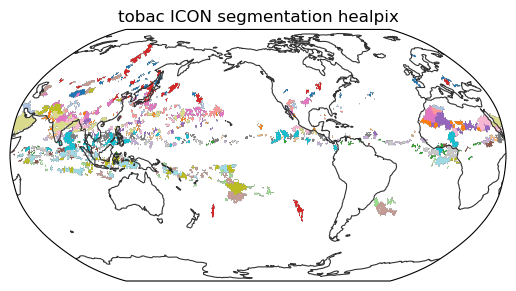

In [244]:
img = egh.healpix_show(segmentation_mask_hp[42].where(segmentation_mask_hp[42]!=0), vmin=34942, vmax=35776, cmap="tab20")
plt.title("tobac ICON segmentation healpix")

We can compare how the number of pixels and the detected area varies between each grid:

In [245]:
Tracks["ncells_healpix"] = np.bincount(segmentation_mask_hp.values.ravel())[Tracks.feature]

Re = 6.371e6
cell_area = 4 * np.pi / (icon_ds.cell.size) * Re**2

Tracks["area_healpix"] = Tracks.ncells_healpix * cell_area

Text(0.5, 1.0, 'Percentage change in number of pixels of detected features')

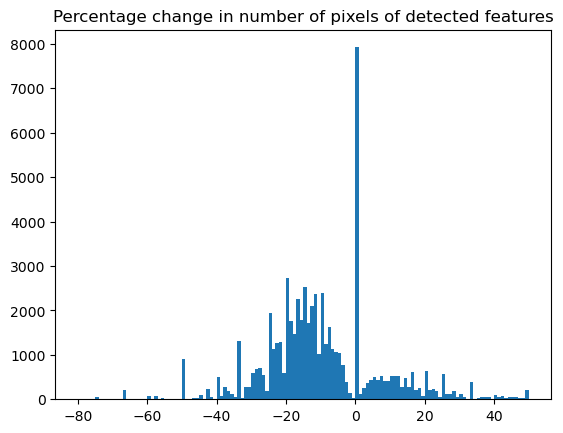

In [246]:
h = plt.hist(
    100 * (Tracks.ncells - Tracks.ncells_healpix) / Tracks.ncells, 
    bins = np.arange(-80,51)
)
plt.title("Percentage change in number of pixels of detected features")

Text(0.5, 1.0, 'Percentage change in area of detected features')

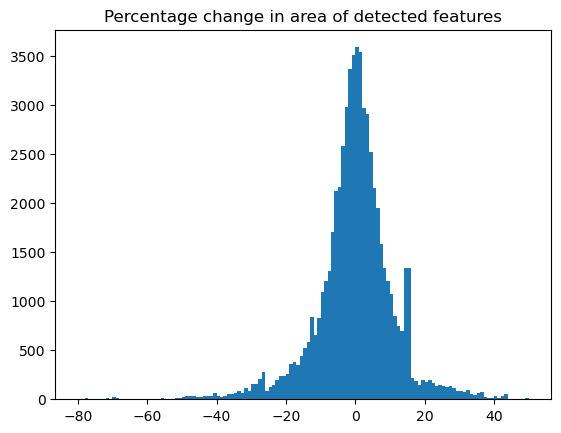

In [247]:
h = plt.hist(
    100 * (Tracks.area - Tracks.area_healpix) / Tracks.area, 
    bins = np.arange(-80,51)
)
plt.title("Percentage change in area of detected features")

## Filtering and analysis of detected storms

With the segmentation mask back on the healpix grid, it is now much easier to perform analysis of the detected features using other model fields from ICON:

In [248]:
Tracks = tobac.utils.bulk_statistics.get_statistics_from_mask(
    Tracks, segmentation_mask_hp, icon_ds.rlut, statistic={"min_OLR": np.nanmin, "mean_OLR": np.nanmean}, default=np.nan
)

Tracks = tobac.utils.bulk_statistics.get_statistics_from_mask(
    Tracks, segmentation_mask_hp, get_tb(icon_ds.rlut), statistic={"min_BT": np.nanmin, "mean_BT": np.nanmean}, default=np.nan
)

Tracks = tobac.utils.bulk_statistics.get_statistics_from_mask(
    Tracks, segmentation_mask_hp, icon_ds.pr* 3.6e3, statistic={"max_precip": np.nanmax, "total_precip":lambda x: np.nansum(x) * cell_area}, default=np.nan
)

In [249]:
Tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,...,ncells,area,ncells_healpix,area_healpix,min_OLR,mean_OLR,min_BT,mean_BT,max_precip,total_precip
0,0,1,35.000000,229.000000,1,250,1,2024-07-01,2024-07-01 00:00:00,72.250000,...,41,3.920810e+10,15,3.891483e+10,150.504700,171.494904,234.262711,244.934723,0.248421,1.817378e+09
1,0,2,39.400000,504.799998,5,250,2,2024-07-01,2024-07-01 00:00:00,70.050000,...,17,1.773668e+10,6,1.556593e+10,155.561234,172.735764,236.926468,245.575577,6.190513,4.588550e+10
2,0,3,43.307692,327.269236,26,250,3,2024-07-01,2024-07-01 00:00:00,68.096154,...,90,1.051071e+11,40,1.037729e+11,150.408356,162.217575,234.211533,240.310791,0.693281,9.539533e+09
3,0,5,49.666667,337.333332,3,250,4,2024-07-01,2024-07-01 00:00:00,64.916667,...,31,4.106963e+10,15,3.891483e+10,154.042068,173.053772,236.130768,245.744308,0.000722,2.402884e+06
4,0,7,53.142857,492.285716,7,250,5,2024-07-01,2024-07-01 00:00:00,63.178571,...,27,3.686691e+10,16,4.150915e+10,139.092285,167.725922,228.080002,242.706146,9.674120,4.912164e+10
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62844,96,1448,198.166667,189.833332,6,325,82401,2024-07-02,2024-07-02 00:00:00,-9.333333,...,35,1.064318e+11,44,1.141502e+11,106.125435,158.877792,208.548080,237.619141,9.257557,7.265292e+10
62845,96,1449,200.400000,194.200002,5,325,82402,2024-07-02,2024-07-02 00:00:00,-10.450000,...,23,6.988180e+10,26,6.745237e+10,96.962082,155.393951,202.544235,235.423019,11.116196,5.220869e+10
62846,96,1450,201.666667,187.333332,3,325,82403,2024-07-02,2024-07-02 00:00:00,-11.083333,...,20,6.059439e+10,22,5.707509e+10,88.018188,156.724945,196.366257,236.186752,14.235356,1.176498e+11
62847,96,1451,203.000000,311.000000,1,325,82404,2024-07-02,2024-07-02 00:00:00,-11.750000,...,31,9.362716e+10,37,9.598992e+10,116.613586,184.129608,215.077286,250.348495,4.686559,4.366517e+10


To investigate MCSs, we can cluster cluster the detected features by their track id to find to total area and rainfall properties

In [250]:
from tobac.utils.periodic_boundaries import weighted_circmean
def process_clusters(tracks):
    groupby_order = ["frame", "track"]
    tracks["cluster"] = -1
    tracks.loc[tracks.track != -1, "cluster"] = (tracks[tracks.track != -1].groupby(groupby_order).feature.cumcount()[tracks[tracks.track != -1].sort_values(groupby_order).index]==0).cumsum().sort_index()
    
    gb_clusters = tracks[tracks.track != -1].groupby("cluster")
    
    clusters = gb_clusters.track.first().to_frame().rename(columns=dict(track="cluster_track_id"))
    
    clusters["cluster_time"] = gb_clusters.time.first().to_numpy()
    
    clusters["cluster_longitude"] = gb_clusters.apply(lambda x:weighted_circmean(x.lon.to_numpy(), x.area.to_numpy(), low=0, high=360), include_groups=False)
    clusters["cluster_latitude"] = gb_clusters.apply(lambda x:np.average(x.lat.to_numpy(), weights=x.area.to_numpy()), include_groups=False)
    
    clusters["cluster_area"] = gb_clusters.area.sum().to_numpy()
    clusters["cluster_max_precip"] = gb_clusters.max_precip.max().to_numpy()
    clusters["cluster_total_precip"] = gb_clusters.total_precip.sum().to_numpy()
    
    return tracks, clusters

In [251]:
Tracks, Clusters = process_clusters(Tracks)

Now we define functions to test if tracks meet the MCSMIP criteria (>10mm/hr max precip and >40,000 km^2 for atleast 4 hours continously, total precip > 2e10 mm for one time step)

In [297]:
def max_time_precip_threshold(df, precip_threshold=10):
    diffs = np.diff((df.cluster_max_precip >= precip_threshold).astype(int))
    time_start = df.cluster_time[1:][diffs==1].to_list()
    time_end = df.cluster_time[:-1][diffs==-1].to_list()

    if df.cluster_max_precip.iloc[0] >= precip_threshold:
        time_start = [df.cluster_time.iloc[0]] + time_start
    if df.cluster_max_precip.iloc[-1] >= precip_threshold:
        time_end = time_end + [df.cluster_time.iloc[-1]]

    if len(time_start) and len(time_end):
        return max([end-start for start, end in zip(time_start, time_end)])
    return pd.NaT


In [299]:
def max_time_area_threshold(df, area_threshold=4e10):
    diffs = np.diff((df.cluster_area >= area_threshold).astype(int))
    time_start = df.cluster_time[1:][diffs==1].to_list()
    time_end = df.cluster_time[:-1][diffs==-1].to_list()

    if df.cluster_area.iloc[0] >= area_threshold:
        time_start = [df.cluster_time.iloc[0]] + time_start
    if df.cluster_area.iloc[-1] >= area_threshold:
        time_end = time_end + [df.cluster_time.iloc[-1]]

    if len(time_start) and len(time_end):
        return max([end-start for start, end in zip(time_start, time_end)])
    return pd.NaT


In [304]:
def is_track_mcs(clusters: pd.DataFrame) -> pd.DataFrame:
    """Test whether each track in features meets the condtions for an MCS

    Parameters
    ----------
    features : pd.Dataframe
        _description_

    Returns
    -------
    pd.DataFrame
        _description_
    """
    consecutive_precip_max = clusters.groupby(["cluster_track_id"]).apply(max_time_precip_threshold, include_groups=False)
    
    consecutive_area_max = clusters.groupby(["cluster_track_id"]).apply(max_time_area_threshold, include_groups=False)
    
    max_total_precip = clusters.groupby(["cluster_track_id"]).cluster_total_precip.max()
    
    is_mcs = np.logical_and.reduce(
        [
            consecutive_precip_max >= pd.Timedelta(4, "hours"),
            consecutive_area_max >= pd.Timedelta(4, "hours"),
            max_total_precip.to_numpy() >= 2e10,
        ]
    )
    mcs_tracks = pd.Series(data=is_mcs, index=consecutive_precip_max.index)
    mcs_tracks.index.name="track"
    return mcs_tracks

In [313]:
mcs_flag = is_track_mcs(Clusters)

In [314]:
mcs_flag

track
1       False
2       False
3       False
4       False
5       False
        ...  
5566    False
5567    False
5568    False
5569    False
5570    False
Length: 5570, dtype: bool

In [321]:
Tracks["mcs_flag"] = False
Tracks.loc[Tracks.track!=-1, ["mcs_flag"]] = mcs_flag[Tracks.track[Tracks.track!=-1]].to_numpy()

In [322]:
Tracks

,frame,idx,hdim_1,hdim_2,num,threshold_value,feature,time,timestr,lat,...,ncells_healpix,area_healpix,min_OLR,mean_OLR,min_BT,mean_BT,max_precip,total_precip,cluster,mcs_flag
0,0,1,35.000000,229.000000,1,250,1,2024-07-01,2024-07-01 00:00:00,72.250000,...,15,3.891483e+10,150.504700,171.494904,234.262711,244.934723,0.248421,1.817378e+09,-1,False
1,0,2,39.400000,504.799998,5,250,2,2024-07-01,2024-07-01 00:00:00,70.050000,...,6,1.556593e+10,155.561234,172.735764,236.926468,245.575577,6.190513,4.588550e+10,1,False
2,0,3,43.307692,327.269236,26,250,3,2024-07-01,2024-07-01 00:00:00,68.096154,...,40,1.037729e+11,150.408356,162.217575,234.211533,240.310791,0.693281,9.539533e+09,2,False
3,0,5,49.666667,337.333332,3,250,4,2024-07-01,2024-07-01 00:00:00,64.916667,...,15,3.891483e+10,154.042068,173.053772,236.130768,245.744308,0.000722,2.402884e+06,3,False
4,0,7,53.142857,492.285716,7,250,5,2024-07-01,2024-07-01 00:00:00,63.178571,...,16,4.150915e+10,139.092285,167.725922,228.080002,242.706146,9.674120,4.912164e+10,4,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62844,96,1448,198.166667,189.833332,6,325,82401,2024-07-02,2024-07-02 00:00:00,-9.333333,...,44,1.141502e+11,106.125435,158.877792,208.548080,237.619141,9.257557,7.265292e+10,50314,True
62845,96,1449,200.400000,194.200002,5,325,82402,2024-07-02,2024-07-02 00:00:00,-10.450000,...,26,6.745237e+10,96.962082,155.393951,202.544235,235.423019,11.116196,5.220869e+10,50622,False
62846,96,1450,201.666667,187.333332,3,325,82403,2024-07-02,2024-07-02 00:00:00,-11.083333,...,22,5.707509e+10,88.018188,156.724945,196.366257,236.186752,14.235356,1.176498e+11,50667,False
62847,96,1451,203.000000,311.000000,1,325,82404,2024-07-02,2024-07-02 00:00:00,-11.750000,...,37,9.598992e+10,116.613586,184.129608,215.077286,250.348495,4.686559,4.366517e+10,50370,False


Now we perform some filtering of the detected tracks, requiring that they meet some basic thresholds: 

1. They belong to a track
2. The track lasts for atleast 1 hour
3. The track reaches a minimum BT below 225 K

In [331]:
track_is_valid = np.logical_and.reduce([
    Tracks.track != -1, 
    (Tracks.groupby("track").time_track.max() >= np.timedelta64(1, "h"))[Tracks.track], 
    (Tracks.groupby("track").min_BT.min() <= 225)[Tracks.track], 
])

In [334]:
Valid_tracks = Tracks[track_is_valid]
MCS_tracks = Valid_tracks[Valid_tracks.mcs_flag]

We can then apply the results of these filters to the segmentation_masks:

In [340]:
valid_segmentation_mask = segmentation_mask_hp.where(np.isin(segmentation_mask_hp, Valid_tracks.feature), 0)
mcs_segmentation_mask = segmentation_mask_hp.where(np.isin(segmentation_mask_hp, MCS_tracks.feature), 0)

Text(0.5, 1.0, 'All valid features')

<Figure size 640x480 with 0 Axes>

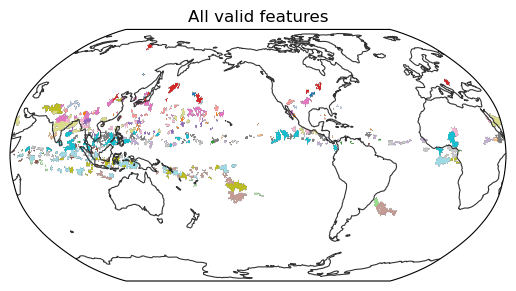

In [341]:
img = egh.healpix_show(valid_segmentation_mask[42].where(valid_segmentation_mask[42]!=0), vmin=34942, vmax=35776, cmap="tab20")
plt.title("All valid features")

Text(0.5, 1.0, 'All MCS features')

<Figure size 640x480 with 0 Axes>

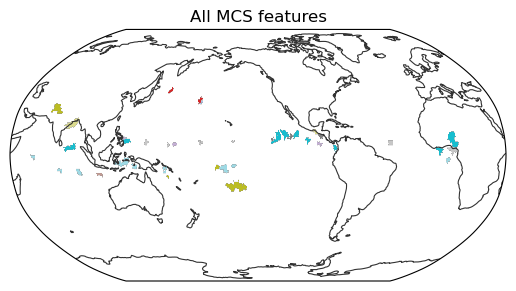

In [342]:
img = egh.healpix_show(mcs_segmentation_mask[42].where(mcs_segmentation_mask[42]!=0), vmin=34942, vmax=35776, cmap="tab20")
plt.title("All MCS features")

Now let's plot the frequency of MCS obs and the proportion of observed storms that are MCS:

Text(0.5, 1.0, 'MCS occurence frequency')

<Figure size 640x480 with 0 Axes>

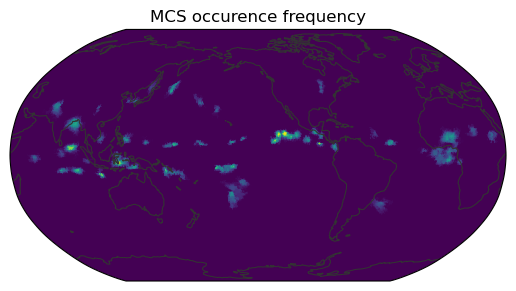

In [344]:
img = egh.healpix_show((mcs_segmentation_mask !=0).mean("time"), vmin=0, vmax=1)
plt.title("MCS occurence frequency")

Text(0.5, 1.0, 'MCS occurence frequency as a proportion of all storms')

<Figure size 640x480 with 0 Axes>

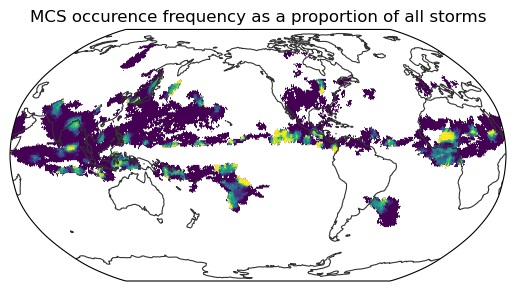

In [345]:
img = egh.healpix_show((mcs_segmentation_mask !=0).mean("time") / (valid_segmentation_mask !=0).mean("time"), vmin=0, vmax=1)
plt.title("MCS occurence frequency as a proportion of all storms")

And the amount of precipitation associated with MCSs:

<Figure size 640x480 with 0 Axes>

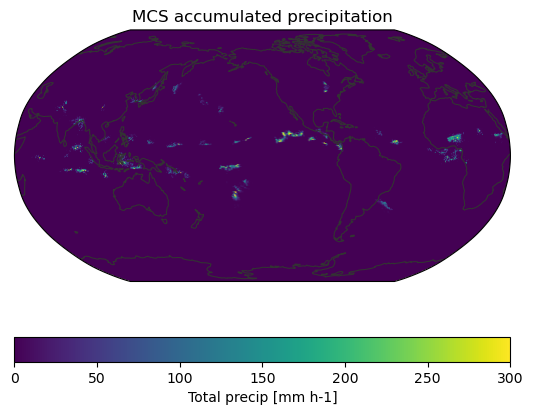

In [350]:
img = egh.healpix_show(icon_ds.pr.where(mcs_segmentation_mask != 0, 0).sum("time") * 3.6e3, vmin=0, vmax=300)
plt.title("MCS accumulated precipitation")
plt.colorbar(img, orientation="horizontal", label="Total precip [mm h-1]")

<Figure size 640x480 with 0 Axes>

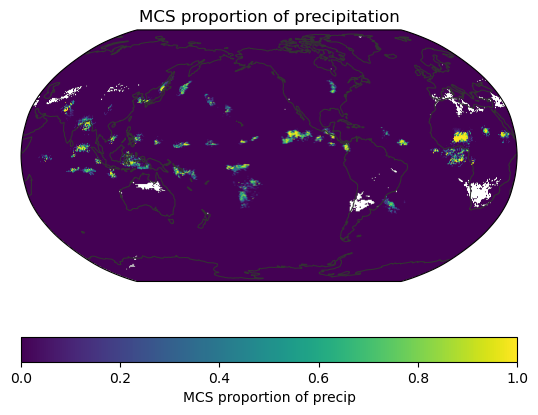

In [351]:
img = egh.healpix_show(icon_ds.pr.where(mcs_segmentation_mask != 0, 0).sum("time") / icon_ds.pr.sum("time"), vmin=0, vmax=1)
plt.title("MCS proportion of precipitation")
plt.colorbar(img, orientation="horizontal", label="MCS proportion of precip")